In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

import matplotlib.pyplot as plt


import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset , random_split
from torchsummary import summary
from torchvision import datasets, transforms, models

# from utils.torch_helper import fn_plot_torch_hist,fn_plot_confusion_matrix

In [4]:
def fn_plot_torch_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas DataFrame with five columns
                First column need to be epoch, 'x' values
                Second and third columns are losses
                fourth and fifth columns are accuracies
    '''
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor=facecolor, alpha=0.5)
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()].head(1) # head one, just incase of multiple lines

    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1,y2], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, 
            transform=ax.transAxes, 
            fontsize=fontsize,
            verticalalignment='top', 
            bbox=props)
    
    # Mark arrow at lowest
    offset = (best[y2].max() - best[y2].max())/10
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left
    ax.grid(True)
    
    # pick second axis
    ax = axes[1]

    # Plot accuracy
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, 
            transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    offset = (best[y4].max() - best[y4].min())/10
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()-2, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.capitalize())
    ax.set_ylabel(y3.capitalize())
    ax.set_title('Accuracies')
    ax.legend(loc = 'lower left')
    ax.grid(True)
    plt.tight_layout()

def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictionary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (4,4))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show()

In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '.'
outDir = '../output'
modelDir = '.'
subDir = 'flower_photos'
altName = 'dnet_flowers'
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE) # set random seed for reproducible results

trainModel = False # True
EPOCHS = 200 # number of epochs
BATCH_SIZE = 32


TRAIN_SIZE = 92*BATCH_SIZE
TEST_SIZE = 0.2

# Input Image size
IMG_HEIGHT = 224 # Lower image size will results in laser accuracy
IMG_WIDTH = 224

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 5

# LEarning rate 
ALPHA = 0.001 # learning rate
WEIGHT_DECAY = 0.01

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [7]:
# # Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## All about CUDA

In [9]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 2060 SUPER


In [10]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


## Read Flowers data set

In [12]:
###---------------
### Transformation
###---------------

transform = transforms.Compose([
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [13]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 224, 224]), 0)

In [14]:
dataset_size = len(dataset)
train_size = TRAIN_SIZE

test_size = dataset_size - train_size
print (dataset_size, train_size, test_size)

3676 2944 732


In [15]:
indices = torch.randperm(len(dataset)).tolist()
#indices

# pick up indices up to test_size
train_dataset = torch.utils.data.Subset(dataset,indices[train_size:])

# pickup from test_size
test_dataset = torch.utils.data.Subset(dataset,indices[:train_size])

In [16]:
len(train_dataset),len(test_dataset)

(732, 2944)

In [17]:
class_names = {}

# Loop over classes
for count, name in enumerate(train_dataset.dataset.classes):
    class_names[count] = name

class_names


{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [18]:
numClasses = len(class_names)
numClasses

5

In [19]:
modelPath =  f'{altName}.pth'

In [20]:
next(iter(train_dataset))[0].shape

torch.Size([3, 224, 224])

## Data Loader

In [22]:
#torch.utils.data.DataLoader?

In [23]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True,
                                               num_workers=4, # Number of parallel data loading workers
                                               persistent_workers=True, # Keep worer alive for caching
                                               prefetch_factor = 8, # preload 4 abtches per worker
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle= True,
                                              num_workers=4,# Number of parallel data loading workers
                                              persistent_workers=True,# Keep worer alive for caching
                                              prefetch_factor = 8, # preload 4 abtches per worker
                                             )


trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

22 92


In [24]:
def fn_showImages(img, ax):
    '''
    Args:
    img: image from torch (c x h x w]
    ax: matplotlib axis object
    '''

    
    img = img.numpy().transpose((1,2,0)) # converting to channel last

    means = np.array([0.485, 0.456, 0.406])
    
    stds = np.array([0.229, 0.224, 0.225])
    
    img = stds * img + means  # normalized data 
    
    img = np.clip(img, 0, 1) # limit value between 0 and 1
    
    ax.imshow(img)
    ax.axis('off')

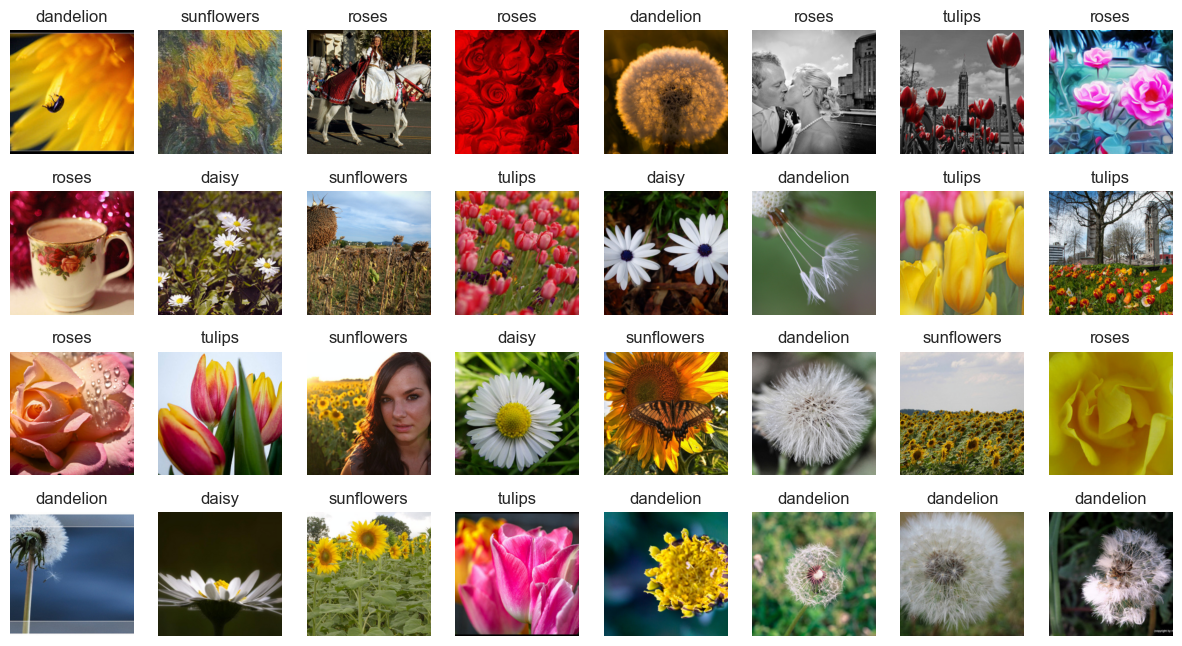

In [25]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].cpu().item()])

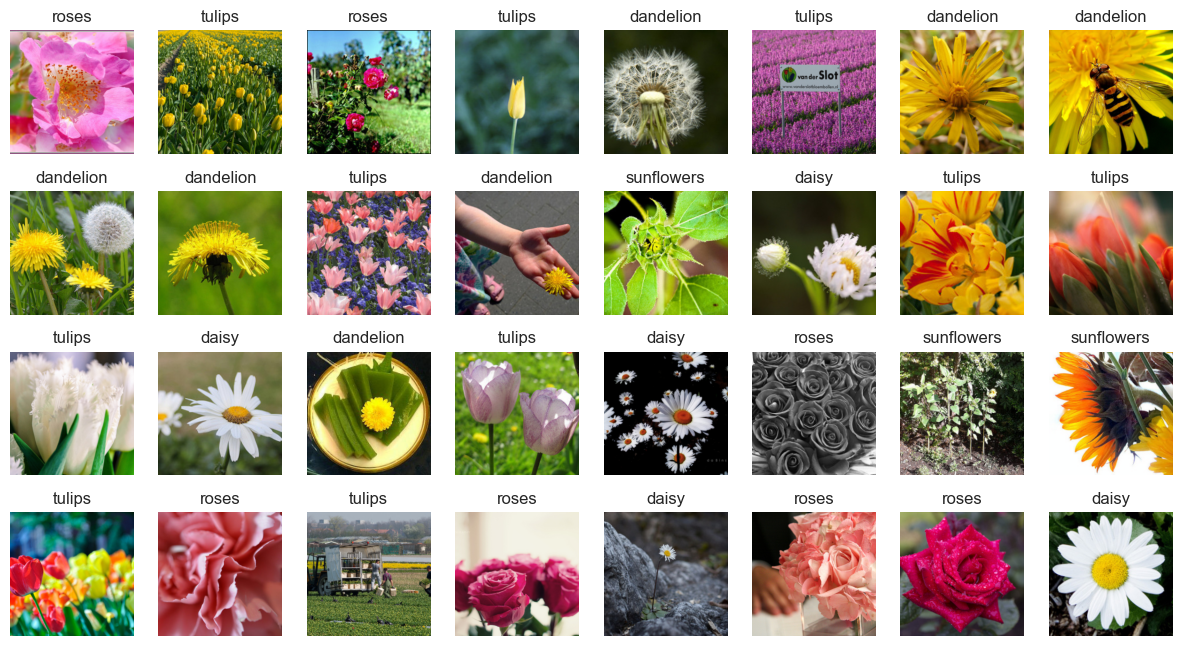

In [26]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].cpu().item()])

In [27]:
# Load pre - trained moel for densenet 
model = models.densenet121(weights='IMAGENET1K_V1')
model.classifier = nn.Linear(model.classifier.in_features, numClasses)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [28]:
class  Earlystopping():
    '''
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    '''
    def __init__(self, patience= PATIENCE, min_delta =0):

        '''
        patience: how many epochs to waits before stopping when loss is 
        not improving 


        min_delta: minimum difference between new loss and old loss for 
            new loss to be considered as an improvement
            
        '''
        self.patience =patience
        self.min_delta =min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss ==None:
            self.best_loss =val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            ## reset counter if validation loss improves
            self.counter = 0

        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            # print(f"[INFO] EArly stopping counter { self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('[INFO] Early stopping')
                self.early_stop = True

In [29]:
class SaveBestModel:
    '''

    Class to save the best ,odel while traing if the iurrent epochs 
    validation loss is less than the previous least less , then save the
    model state
    '''
    def __init__(self, best_test_loss = float ('inf'), bestModelPath = modelPath):
        self.best_test_loss = best_test_loss
        self.modelPath = bestModelPath

    def __call__(self, current_test_loss, epoch, model, optimizer, criterion):
        if current_test_loss < self.best_test_loss:

            self.best_test_loss = current_test_loss
            print(f"[INFO]: saving at epochs : { epoch+1}")
            torch.save({'epoch': epoch +1,
                        'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
                       },self.modelPath)

In [30]:
# Move  model to device
model = model.to(device)

# initialize our optimizer and loss function
# lr = 0.001,betas =(0.9,0.999), eps = le-08, weigh_decay =0.01
optimizer = torch.optim.AdamW(model.parameters(), lr = ALPHA, weight_decay= WEIGHT_DECAY)


loss_fn = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=LR_FACTOR,
    patience=LR_PATIENCE,
    min_lr= 1e-7
)

early_stopping = Earlystopping(patience= PATIENCE)
save_best_model = SaveBestModel()

# initilize a dictionary to store training history
H={
    'Epoch' :[],
    'train loss':[],
    'Test loss':[],
    'Train acc':[],
    'Test acc' : [],
    'Alpha':[],
    'Patience':[]
}

In [31]:
if trainModel:
    print("[INFO] training the network...")
    startTime = time.time()

    for epoch in range (0, EPOCHS):
        epochStart = time.time()

        model.train()

        avgTrainLoss = 0
        avgTestLoss = 0
        y_pred = []
        y_tune =[]

        for count, data in enumerate(train_dataloader):

            images, labels =data

            images = images.to(device)
            label = labels.to(device)

            optimizer.zero_grad()


            outputs = model (images)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            avgTrainLoss+=(loss.item() - avgTrainLoss)/(count+1)

            y_true.extend(labels.cpu().numpy())

            y_pred.extend(outputs.argmax(axis=1).cpu().numpy())

        trainAcc = accuracy_score(y_true, y_pred)

        y_pred =[]
        y_true = []

        with torch.no_grad():

            model.eval()

            # loop over the validation set
            for count, data in enumerate(test_dataloader):
    
                images, labels =data
                # send the input to the device
                images = images.to(device)
                label = labels.to(device)
                
                # make the predictions and calculate the validationloss
                outputs = model (images)
                avgTrainLoss+=(loss_fn(output, labels).item() - avgTrainLoss)/(count+1)

                # add labels to the list
                y_true.extend(labels.cpu().numpy())

                # add predictions to the list
                y_pred.extend(outputs.argmax(axis=1).cpu().numpy())

            # calling learning rate scheduler
            lr_scheduler.step(avgTestLoss)

            save_best_model(avgTestLoss,epoch, model, optimizer,  loss_fn)

            early_stopping(avgTestLoss)

            testAcc = accuracy_score(y_true, y_pred)

            # calculate the average training and validation loss
            curr_alpha = lr_scheduler.get_last_lr()[0]

            H['Epoch'].append(epoch)
            H['Train loss'].append(avgTrainLoss)
            H['Test loss'].append(avgTestLoss)
            H['Train acc'].append(trainAcc)
            H['Test acc'].append(testAcc)
            H['Alpha'].append(curr_alpha)
            H['Patience'].append(early_stopping.counter)

            #   print the model training and validation information
            print(f"[INFO] EPOCH: {epoch+1}/{EPOCHS}", end ='')
            print(f"Loss:{avgTrainLoss:.6f}/{avgTestLoss:.6f},Accuracy:{trainAcc:.4f}/{testAcc:.4f}",end='')
            print(f"Alpha:{curr_alpha:.6f}/{avgTestLoss:.6f},ES:{early_stopping.counter:3d}", end = '')
            print("in: {:.2f}s\n".format(time.time() -epochStart))

        if early_stopping.early_stop:
            break

    # finish measuring how long training took
    endTime = time.time()
    print(f"[IFO] total time taken to train  the model: {(endTime - startTime)/60.:.2f}min")

else:
    model_data = torch.load(modelPath, weights_only= False)
  
    #setting state
    model.load_state_dict(model_data['model_state_dict'])


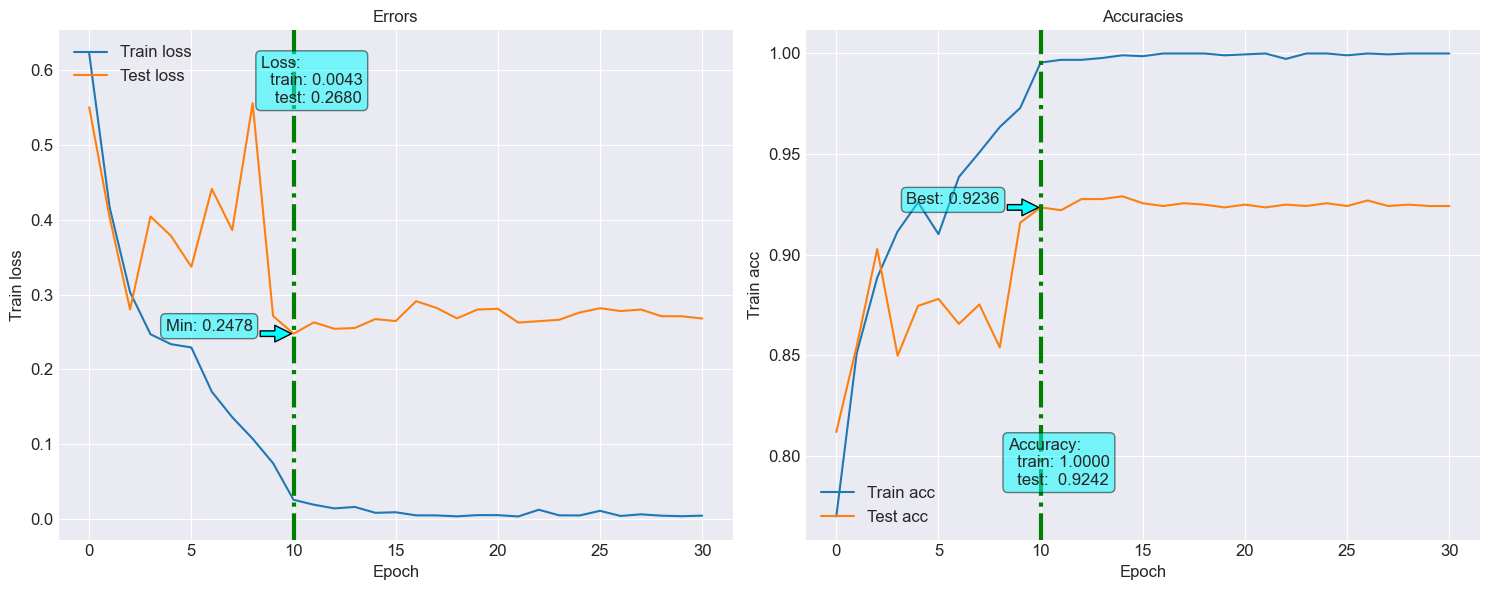

In [32]:
if trainModel :
    loss_df = pd.DataFrame(H)
    loss_df.to_csv( f'{altName}.csv', index = False)

else:
    loss_df = pd.read_csv( f'{altName}.csv')

fn_plot_torch_hist(loss_df)

### How well i know my training

In [34]:
# turn off autograd for testing evaluation
with torch.no_grad():

            model.eval()

            y_pred =[]
            y_true =[]
            # loop over the validation set
            for data in train_dataloader:
    
                images, labels =data
                # send the input to the device
                images = images.to(device)
            
                y_true.extend(labels)
                # make the predictions and calculate the validationloss
                outputs = model (images)
               
                y_pred.extend(outputs.argmax(axis=1).cpu().numpy())


In [35]:
print(f'Accuracy score : {accuracy_score(y_true, y_pred) : .5f}\n')

print(classification_report(y_true,y_pred,
                            target_names=class_names.values()))

Accuracy score :  0.96858

              precision    recall  f1-score   support

       daisy       0.99      0.98      0.98       136
   dandelion       0.97      0.97      0.97       172
       roses       0.95      0.97      0.96       134
  sunflowers       0.99      0.96      0.97       139
      tulips       0.95      0.97      0.96       151

    accuracy                           0.97       732
   macro avg       0.97      0.97      0.97       732
weighted avg       0.97      0.97      0.97       732



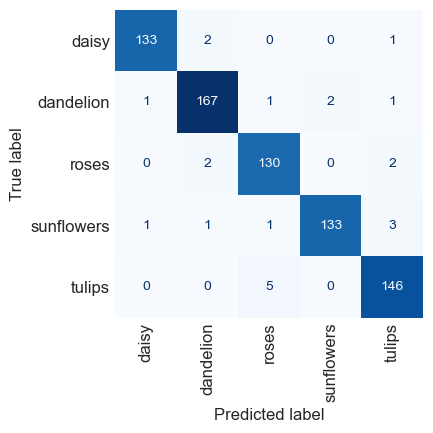

In [36]:
fn_plot_confusion_matrix(y_true, y_pred,class_names)

In [37]:
f1_score(y_true, y_pred, average="weighted")

0.9686239618035952

In [38]:
def fn_display_batches(n_batches, dataloader):

    for batch in range(n_batches):
        
        #Run this to test your data loader
        images, labels = next(iter(dataloader))

        # predict again to keep y _pred in synch with the images
        images = images.to(device)
        output = model(images)

        y_pred = output.argmax(axis = 1).cpu()

        # set figure size
        fig = plt.figure(figsize = (15,4)) # Figure size in inches with default params

        # Adjust the subplot layout parameters
        fig.subplots_adjust(left =0., # as a fraction of the figure width
                            right=1.,# use full width, as a fraction of the figure width
                            bottom=0.,# as a fraction of the figure height
                            top=1.,# as a fraction of the figure height
                            hspace=0.05,# as a fraction of the average axes height
                           )
        fontsize =12

        for i in range (BATCH_SIZE):
            if labels[i]!=y_pred[i]:
                fc ='red'
                ec ='red'
                text_color = 'yellow'
            else:
                fc ='cyan'
                ec = 'blue'
                text_color ='blue'

            props = dict(boxstyle='round', facecolor=fc, alpha=0.7, ec=ec)

            ax = fig.add_subplot(BATCH_SIZE//8,8,(i+1),xticks=[], yticks=[]) # 

            fn_showImages(images[i].cpu(), ax = ax)
            #

            ax.text(0.1,0.95, class_names[y_pred[i].item()],transform=ax.transAxes,
                    fontsize=fontsize, color= text_color,
                verticalalignment ='top',bbox=props) # add number (class) of the images

            ax.set_title(class_names[labels[i].item()])

            ax.axis("off")

        plt.tight_layout()
        plt.show()
            

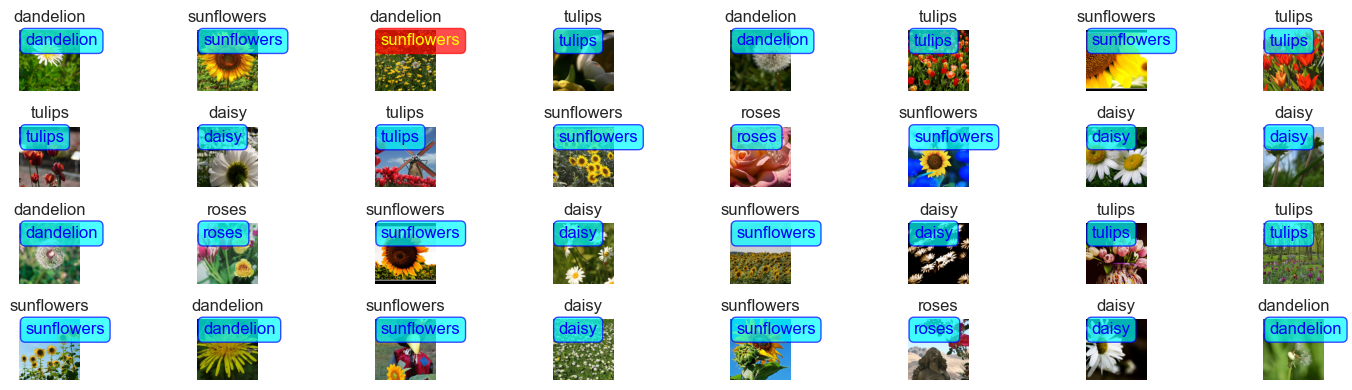

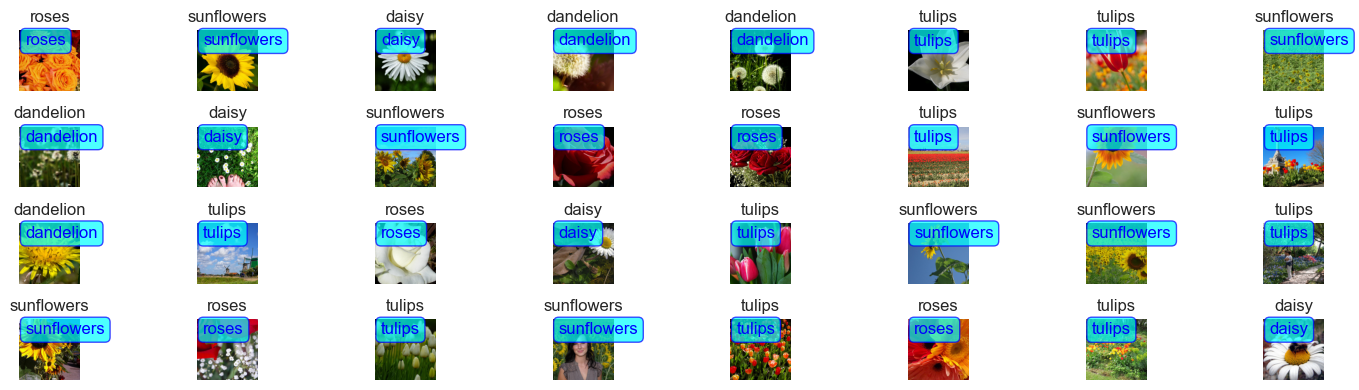

In [39]:
fn_display_batches(2, train_dataloader)

In [40]:
# turn off autograd for testing evaluation
with torch.no_grad():

            model.eval()

            y_pred =[]
            y_true =[]
            # loop over the validation set
            for data in test_dataloader:
    
                images, labels =data
                # send the input to the device
                images = images.to(device)
            
                y_true.extend(labels)
                # make the predictions and calculate the validationloss
                outputs = model (images)
               
                y_pred.extend(outputs.argmax(axis=1).cpu().numpy())


In [41]:
print(f'Accuracy score : {accuracy_score(y_true, y_pred) : .5f}\n')

print(classification_report(y_true,y_pred,
                            target_names=class_names.values()))

Accuracy score :  0.97011

              precision    recall  f1-score   support

       daisy       0.99      0.97      0.98       503
   dandelion       0.98      0.98      0.98       726
       roses       0.95      0.97      0.96       507
  sunflowers       0.98      0.97      0.97       560
      tulips       0.95      0.96      0.96       648

    accuracy                           0.97      2944
   macro avg       0.97      0.97      0.97      2944
weighted avg       0.97      0.97      0.97      2944



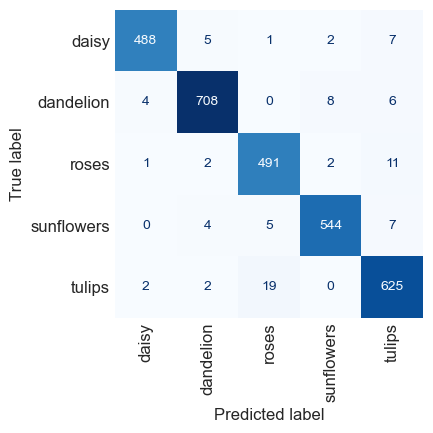

In [42]:
fn_plot_confusion_matrix(y_true, y_pred,class_names)

In [43]:
f1_score(y_true, y_pred, average="weighted")

0.9701610330930689

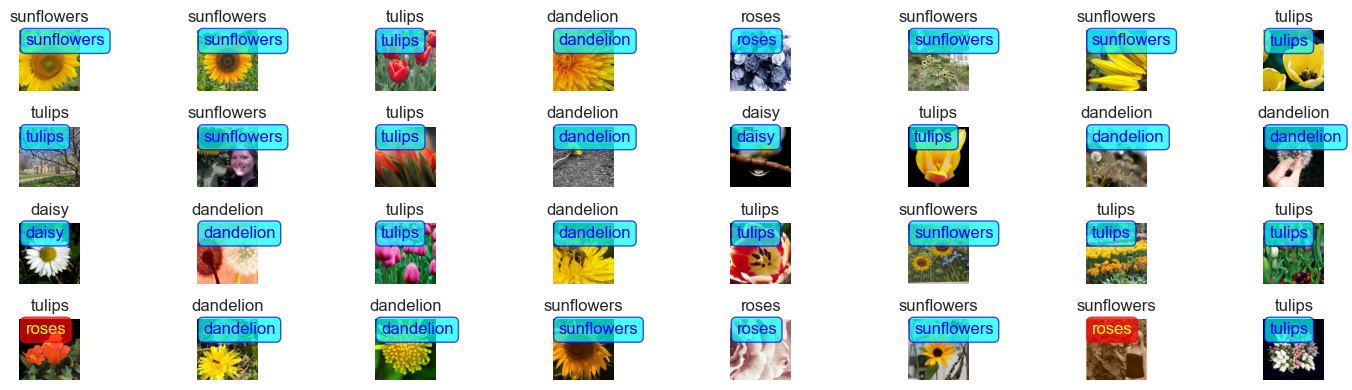

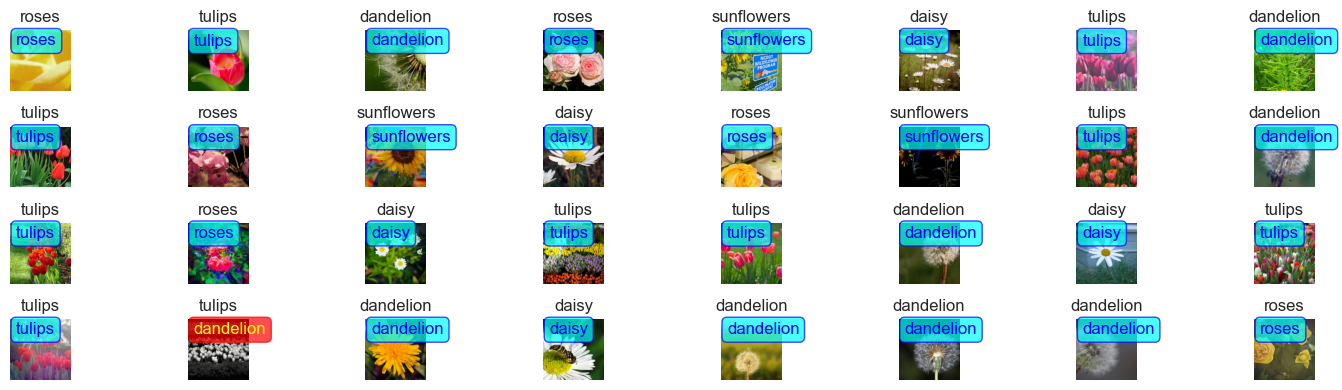

In [81]:
fn_display_batches(2, test_dataloader)

In [91]:
valDir = 'valid_flowers'

valid_dataset = datasets.ImageFolder(valDir,
                                     transform=transform)

valid_dataloader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle= True,
                                              num_workers=4,# Number of parallel data loading workers
                                              persistent_workers=True,# Keep worer alive for caching
                                              prefetch_factor = 8, # preload 4 abtches per worker
                                             )

In [93]:
# turn off autograd for testing evaluation
with torch.no_grad():

            model.eval()

            y_pred =[]
            y_true =[]
            # loop over the validation set
            for data in valid_dataloader:
    
                images, labels =data
                # send the input to the device
                images = images.to(device)
            
                y_true.extend(labels)
                # make the predictions and calculate the validationloss
                outputs = model (images)
               
                y_pred.extend(outputs.argmax(axis=1).cpu().numpy())

In [95]:
print(f'Accuracy score : {accuracy_score(y_true, y_pred) : .5f}\n')

print(classification_report(y_true,y_pred,
                            target_names=class_names.values()))

Accuracy score :  0.87446

              precision    recall  f1-score   support

       daisy       0.97      0.86      0.92        44
   dandelion       0.89      0.93      0.91        42
       roses       0.86      0.82      0.84        45
  sunflowers       0.92      0.90      0.91        50
      tulips       0.77      0.86      0.81        50

    accuracy                           0.87       231
   macro avg       0.88      0.87      0.88       231
weighted avg       0.88      0.87      0.88       231



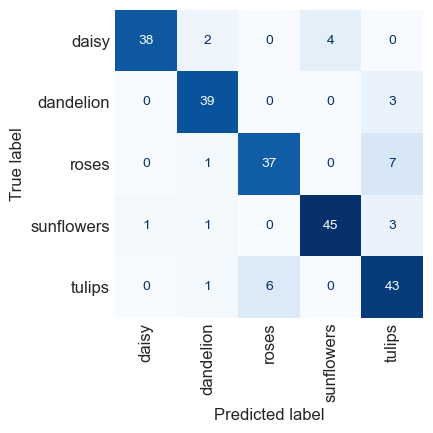

In [97]:
fn_plot_confusion_matrix(y_true, y_pred,class_names)

In [99]:
f1_score(y_true, y_pred, average="weighted")

0.8755137323100588

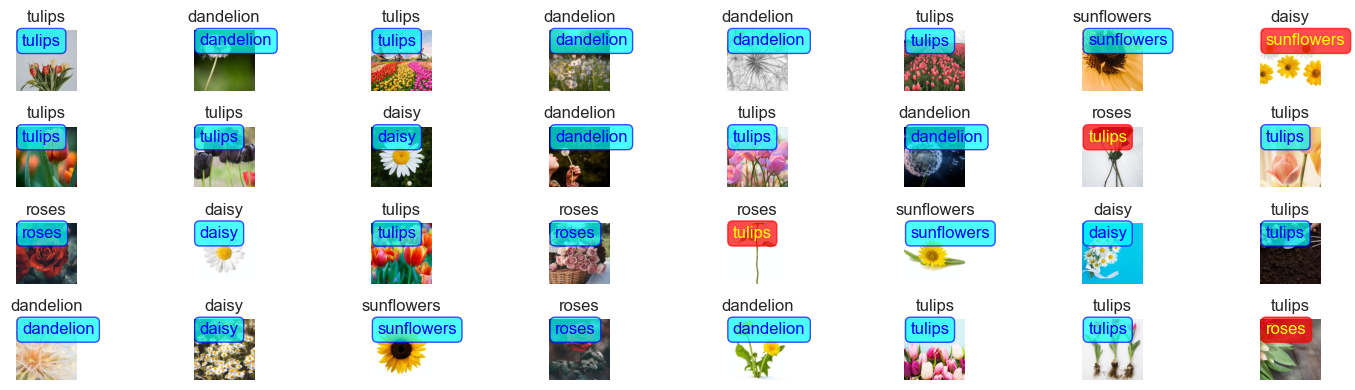

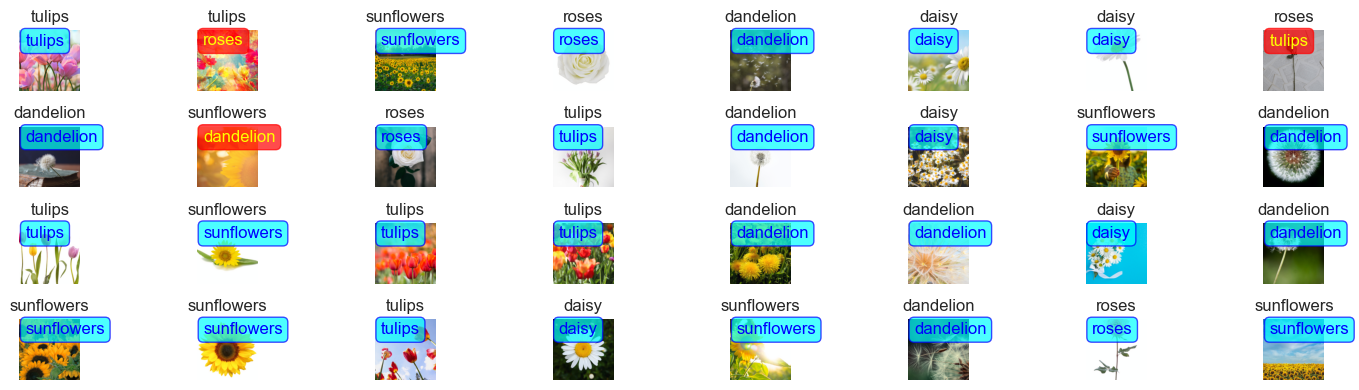

In [103]:
fn_display_batches(2, valid_dataloader)